In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('bmh')

from numpy.linalg import cond
from numpy.linalg import solve
from scipy.sparse.linalg import spsolve

from rum.basics import matprint
from rum.grid import UniformGrid, Field
from rum.operators import LAPL

# Aufgabe 1


Given the Poission problem:

$
div \left( grad \left( \theta \left( x , y \right) \right) \right) = \Delta \theta = 0 \\
\omega = [0,1] x [0,1] \\
$

Auf dem Rand:

$
\begin{align}
a \left( sin \left( \omega x \right) + sin \left( \omega y \right) \right) + 293 K = \theta \left( x,y \right) \\ 
\left( \omega \gt 0 \right) \\
\end{align}
$


In [30]:
# ## Generate a uniform grid

# In[9]:


h = 0.02
xrange = 1.0
yrange = 1.0
field = Field(xrange=xrange, yrange=yrange, h=h, initialvalue = 0.0)

# ## Set boundary conditions

# In[11]:


def theta_bc(x: float, y: float, a: float, omega: float):
    "Returns boundary temperature in degress Celcius"
    return a*(np.sin(omega * x) + np.sin(omega * y)) + 293


freq = 1.0
omega = 2*freq*np.arccos(-1)
amp = 200.0
def bc_func(x, y): return theta_bc(x, y, amp, omega)

sizex, sizey = field.shape

i_indices = sizey*[0]
j_indices = range(sizey)
field.setboundary(i_indices, j_indices, bc_func)

i_indices = sizey*[sizex-1]
j_indices = range(sizey)
field.setboundary(i_indices, j_indices, bc_func)

i_indices = range(sizex)
j_indices = sizey*[0]
field.setboundary(i_indices, j_indices, bc_func)

i_indices = range(sizex)
j_indices = sizex*[sizey-1]
field.setboundary(i_indices, j_indices, bc_func)

# ## Laplace Operator

# In[13]:


L = LAPL(field.shape[0])

# ### Generate paritioning matrices $L_E$ and $L_F$

# In[17]:

fieldx, fieldy = field.shape


boundary = np.ones([fieldx, fieldy], dtype=int)
boundary[1:-1,1:-1] = 0

numboundary = sum(boundary.flatten())
numinner = boundary.size - sum(boundary.flatten())


LfT = sparse.lil_matrix((numinner,fieldx*fieldy),dtype='i')
LeT = sparse.lil_matrix((numboundary,fieldx*fieldy),dtype='i')
n_LfT, n_LeT = 0,0
for i in range(fieldx):
    for j in range(fieldy):
        if boundary[i,j] == 0:
            LfT[n_LfT,fieldx*i+j] = 1
            n_LfT += 1
        elif boundary[i,j] == 1:
            LeT[n_LeT,fieldx*i+j] = 1
            n_LeT += 1
        else:
            raise ValueError("test")
        
LfT = LfT.tocsr()
Lf = LfT.T
LeT = LeT.tocsr()
Le = LeT.T

# ### $L_{mod}$

# In[18]:


K = L  # laplace operator matrix
Lmod = LfT.dot(K).dot(Lf)

# $
# rhs_{mod} = L_F^T K L_E \theta_{E}
# $

# In[20]:


theta_E = LeT.dot(field.asvector())
rhs_mod = - LfT.dot(K).dot(Le).dot(theta_E)


# ## Solve $ L_{mod} \theta_{mod} = rhs_{mod}$

# In[24]:


theta_mod = spsolve(A=Lmod,b=rhs_mod)


# ## Reassemble

# In[26]:


fieldx, fieldy = field.shape

theta_inner_final = Lf.dot(theta_mod)
theta_boundary_final  = Le.dot(theta_E)
theta_final = theta_inner_final + theta_boundary_final

assert (len(theta_final) == fieldx*fieldy)
field.values = theta_final

print("Completed.")

Completed.


<IPython.core.display.Javascript object>


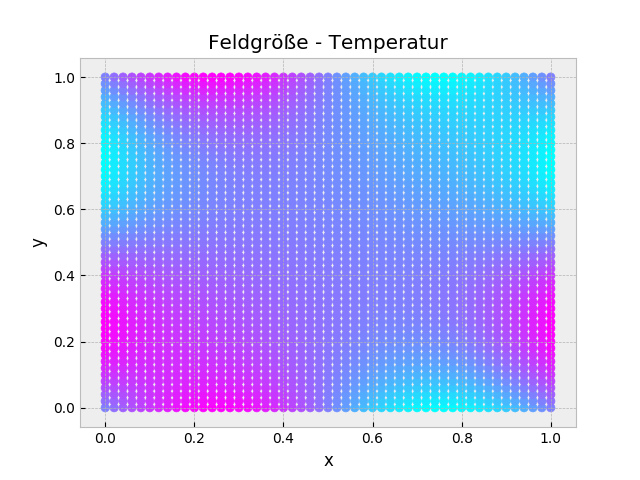

In [31]:
%matplotlib notebook
plt = field.plot()
plt.title("Feldgröße - Temperatur")
plt.show()

In [32]:
print("Average temperature: {}".format(field.values.mean()))

Average temperature: 292.99999999999966
